In [70]:
import src.merge_utils.merge_fb as fmerge
import torch 
from matplotlib import pyplot as plt
import pandas as pd


In [2]:
import os
import numpy as np
import itertools
import math, random
random.seed = 42

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from pathlib import Path
import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [20]:
square_shape = 4
rands = torch.rand((1,square_shape**2,3))
rands.shape

torch.Size([1, 16, 3])

In [21]:
merge_func, unmerge_func = fmerge.bipartite_soft_matching(rands, 3)


In [22]:
unmerge_func(merge_func(rands)).shape

torch.Size([1, 16, 3])

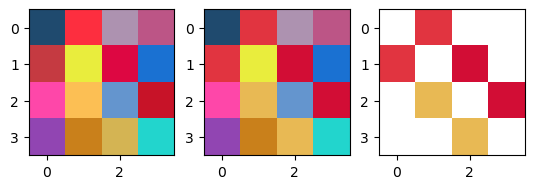

In [23]:
plt.subplot(131)
plt.imshow(torch.reshape(rands,(square_shape,square_shape,-1)))
plt.subplot(132)
compressed = unmerge_func(merge_func(rands))
plt.imshow(torch.reshape(compressed,(square_shape,square_shape,-1)))
plt.subplot(133)
masked = torch.where(compressed != rands,compressed, 1)
plt.imshow(torch.reshape( masked,(square_shape,square_shape,-1)))


In [67]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
        layout=go.Layout(
            updatemenus=[dict(type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                        )]
                    )
                ])]
        ),
        frames=frames
    )

    return fig


def pcshow(xs,ys,zs,pointsize=7):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers',)]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=pointsize,
                      line=dict(width=7,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

   

In [89]:
 
def pcshowmulti(pointsize=7,**kwargs):
    pclouds = []
    for name,data in kwargs.items() :
        df = pd.DataFrame(data,columns=['x','y','z'])
        df['type'] = name 
        pclouds.append(df)
    df = pd.concat(pclouds)
    fig = px.scatter_3d(df, x='x', y='y', z='z',
              symbol='type',color='type', opacity=0.7)

    # tight layout
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.update_traces(marker=dict(size=pointsize))
    fig.show()

In [90]:
pointcloud = torch.rand((1,10,3))
pmerger, punmerger = fmerge.bipartite_soft_matching(pointcloud,5)
merged = pmerger(pointcloud)
compressed = punmerger(pmerger(pointcloud))
print(pointcloud.shape, merged.shape, compressed.shape)

torch.Size([1, 10, 3]) torch.Size([1, 5, 3]) torch.Size([1, 10, 3])


In [94]:
pcshowmulti(pointcloud =pointcloud[0], merged = merged[0], compressed = compressed[0],pointsize=7)

In [97]:
path = Path("./data/modelnet40")

def read_off(file):
    off_header = file.readline().strip()
    if 'OFF' == off_header:
        n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    else:
        n_verts, n_faces, __ = tuple([int(s) for s in off_header[3:].split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

with open(path/"car/train/car_0012.off", 'r') as f:
    verts, faces = read_off(f)

class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
    
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

n_sample = 600
k_subsample =  0.4

pointcloud = PointSampler(n_sample)((verts, faces))

norm_pointcloud = torch.from_numpy(Normalize()(pointcloud)).unsqueeze(0)
print(norm_pointcloud.shape)

pmerger, punmerger = fmerge.bipartite_soft_matching(norm_pointcloud,int(n_sample*k_subsample))
pc_merged = pmerger(norm_pointcloud)
pc_compressed = punmerger(pmerger(norm_pointcloud))

pointsize = 4

# pcshow(*norm_pointcloud[0].T, pointsize=pointsize)
# pcshow(*merged[0].T, pointsize=pointsize)
# pcshow(*compressed[0].T, pointsize=pointsize)
pcshowmulti(pointcloud =norm_pointcloud[0], merged = pc_merged[0], compressed = pc_compressed[0],pointsize=4)

torch.Size([1, 600, 3])
